In [1]:
setwd('/Users/alexis/University of North Carolina at Chapel Hill - Rager, Julia - CEMALB_DataAnalysisPM/Projects/P1003. Ozone Sterols Healthy Asthma/P1003.3. Analyses/P1003.3.4. ML Visualizations/P1003.3.4.2. ICE Plot/Input')
Output = ('/Users/alexis/University of North Carolina at Chapel Hill/Rager, Julia - CEMALB_DataAnalysisPM/Projects/P1003. Ozone Sterols Healthy Asthma/P1003.3. Analyses/P1003.3.4. ML Visualizations/P1003.3.4.2. ICE Plot/Output')
cur_date = "040722"

library(readxl)
library(tidyverse)
library(caret)
library(randomForest)

#reading in files
ozone_data = data.frame(read_excel("Imputed_Ozone_Data_022822.xlsx")) 
demographics_data = data.frame(read_excel("SubjectInfo_011822.xlsx", sheet = 2))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


randomForest 4.7-1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




In [2]:
head(ozone_data)
head(demographics_data)

,Original_Subject_No,Subject_No,Subject_ID,Disease_Status,Sample_Type,Time_Point,Inflammatory_Responder,Lung_Responder,Category,Variable,Value
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,Sample_Weight,817.00
2,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,TCC,395000.00
3,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,TCC_Weight,483.48
4,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,Neutrophils_Percent,25.00
5,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,Neutrophils,98750.00
6,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,Neutrophils_Weight,121.00


,Original_Subject_No,Subject_No,Subject_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Visit_Season
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,4,1,AS_1,M,W,NH,30,23.3,AS,Fa
2,7,2,AS_2,F,W,NH,39,32.7,AS,Sp
3,11,3,AS_3,M,W,NH,23,23.0,AS,Fa
4,13,4,AS_4,M,W,NH,20,21.4,AS,Wi
5,15,5,AS_5,F,B,NH,20,34.5,AS,Su
6,16,6,AS_6,F,W,NH,25,25.2,AS,Su


In supervised machine learning, Decision Boundaries help assess how well two predictors (on the x and y axis) separate different classes in classification. A clear decision boundary has most classes well separated. 

In [3]:
#getting baseline plasma data (not using covariates)
plasma_baseline_ozone_data = ozone_data %>%
    #only interested in plasma soluble mediators (cytokines/sterols) at baseline
    filter(Sample_Type == "P" & Time_Point == "Pre") %>%
    filter(Category == "Cytokine" | Category == "Sterol") %>%
    select(-c("Sample_Type", "Time_Point", "Category")) %>%
    distinct()
head(plasma_baseline_ozone_data)

,Original_Subject_No,Subject_No,Subject_ID,Disease_Status,Inflammatory_Responder,Lung_Responder,Variable,Value
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,4,1,AS_1,AS,NR,NR,IFNg,8.0557406
2,4,1,AS_1,AS,NR,NR,IL10,0.3476302
3,4,1,AS_1,AS,NR,NR,IL12p70,0.4572941
4,4,1,AS_1,AS,NR,NR,IL13,7.7955008
5,4,1,AS_1,AS,NR,NR,IL1b,0.2763808
6,4,1,AS_1,AS,NR,NR,IL2,0.5728830


In [4]:
#first pivoting wider bc thats what random forest prefers
wider_data = pivot_wider(plasma_baseline_ozone_data,
                         #not actually taking the mean of multiple values
                         #did this bc cols would be type list rather than double
                         names_from = Variable, values_from = Value, values_fn = mean)

head(wider_data)

Original_Subject_No,Subject_No,Subject_ID,Disease_Status,Inflammatory_Responder,Lung_Responder,IFNg,IL10,IL12p70,IL13,⋯,SecoB,bEP_Chol,Lan,Zym,DHL,Des,dHLan,Zyme,Lath,Chol
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,1,AS_1,AS,NR,NR,8.055741,0.3476302,0.4572941,7.795501,⋯,1.816,25.669,0.171,0.057,0.224,0.641,0.004,3.014,1.969,1110.442
7,2,AS_2,AS,R,NR,5.456212,0.1802846,0.1292934,2.917929,⋯,112.521,17.867,0.062,0.046,0.106,0.286,0.015,2.508,1.287,673.328
11,3,AS_3,AS,NR,R,2.902175,0.4177936,0.2590372,5.633180,⋯,6.686,8.066,0.052,0.046,0.094,0.279,0.005,1.549,1.200,537.509
13,4,AS_4,AS,R,NR,3.860980,0.3901140,0.2232882,5.927085,⋯,48.416,10.132,0.013,0.046,0.085,0.297,0.016,1.833,1.062,482.396
15,5,AS_5,AS,R,NR,2.652720,0.2658850,0.4454673,4.514058,⋯,13.006,13.090,0.117,0.060,0.116,0.255,0.020,3.628,1.795,586.750
16,6,AS_6,AS,NR,NR,22.007931,0.4377489,0.1994178,4.951412,⋯,36.458,14.331,0.022,0.034,0.077,0.272,0.006,1.914,0.966,639.636


In [5]:
#making responder columns binary denoted by 0 = non-responder and 1 = responder 
wider_data = wider_data %>%
    mutate(Lung_Responder = relevel(factor(ifelse(Lung_Responder == "R", 1, 0)), ref = "0")) %>%
    #for some reason RF didn't this variable so I changed it
    rename(X25OH_VitD = `25OH_VitD`)
lung_resp_df = wider_data[,6:47]

head(lung_resp_df)

Lung_Responder,IFNg,IL10,IL12p70,IL13,IL1b,IL2,IL4,IL6,IL8,⋯,SecoB,bEP_Chol,Lan,Zym,DHL,Des,dHLan,Zyme,Lath,Chol
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,8.055741,0.3476302,0.4572941,7.795501,0.2763808,0.5728830,0.08653851,4.27020432,624.862506,⋯,1.816,25.669,0.171,0.057,0.224,0.641,0.004,3.014,1.969,1110.442
0,5.456212,0.1802846,0.1292934,2.917929,0.1416200,0.0616800,0.00492000,0.22680099,28.767470,⋯,112.521,17.867,0.062,0.046,0.106,0.286,0.015,2.508,1.287,673.328
1,2.902175,0.4177936,0.2590372,5.633180,0.1416200,0.0616800,0.03890678,0.15432565,4.411786,⋯,6.686,8.066,0.052,0.046,0.094,0.279,0.005,1.549,1.200,537.509
0,3.860980,0.3901140,0.2232882,5.927085,0.1416200,0.1127180,0.03740718,0.47849981,2.909993,⋯,48.416,10.132,0.013,0.046,0.085,0.297,0.016,1.833,1.062,482.396
0,2.652720,0.2658850,0.4454673,4.514058,0.1416200,0.0616800,0.02353853,0.07186388,3.387921,⋯,13.006,13.090,0.117,0.060,0.116,0.255,0.020,3.628,1.795,586.750
0,22.007931,0.4377489,0.1994178,4.951412,0.1416200,0.2333793,0.02990994,1.54397048,3.779592,⋯,36.458,14.331,0.022,0.034,0.077,0.272,0.006,1.914,0.966,639.636


# Random Forest

In [6]:
rf_classification = function(dataset, outcome, pred_outcome){
    # setting for reproducibility
    set.seed(12)
    # splitting data into training and testing sets
    dataset_index = createFolds(dataset[[outcome]], k = 5) # 5 fold CV

    rf_models = list()
    
    for (i in 1:length(dataset_index)){
        data_train = dataset[-dataset_index[[i]],]
        data_test = dataset[dataset_index[[i]],]

        ntree_values = c(50, 250, 500) # number of trees (not sure if we wanted something different)
        p = dim(dataset)[2] - 1 # number of variables in dataset
        mtry_values = c(p/2, sqrt(p), p)

        # will use ntree and mtry values to determine which combination yields the smallest MSE
        reg_rf_pred_tune = list()
        rf_OOB_errors = list()
        rf_error_df = data.frame()
        for (j in 1:length(ntree_values)){
            for (k in 1:length(mtry_values)){
                reg_rf_pred_tune[[k]] = randomForest(as.formula(paste0(outcome, "~.")), data = data_train, 
                                                     ntree = ntree_values[j], mtry = mtry_values[k])
                rf_OOB_errors[[k]] = data.frame("Tree Number" = ntree_values[j], "Variable Number" = mtry_values[k], 
                                       "OOB_errors" = reg_rf_pred_tune[[k]]$err.rate[ntree_values[j],1])
                rf_error_df = rbind(rf_error_df, rf_OOB_errors[[k]])
            }
        }

        # finding the lowest OOB error using best number of predictors at split and refitting OG tree
        best_oob_errors <- which(rf_error_df$OOB_errors == min(rf_error_df$OOB_errors))

        reg_rf <- randomForest(as.formula(paste0(outcome, "~.")), data = data_train,
        # need to go back and figure out how the number of trees/ variables make a difference even though
        # the errors are the same!!!!
                               ntree = rf_error_df$Tree.Number[min(best_oob_errors)], 
                               mtry = rf_error_df$Variable.Number[min(best_oob_errors)])

        rf_models = list(rf_models, reg_rf)
        
#         X <- lung_resp_df[which(names(lung_resp_df) != "Lung_Responder")]
#         plot = partialPlot(rf_models_lung_resp[[1]], pred.data = X, x.var = "X25OH_VitD")  # Figure 2
    }
    
    # return each rf model
    return(rf_models)

}

#calling fn
rf_models_lung_resp = rf_classification(lung_resp_df, "Lung_Responder", "pred_Lung_Responder")

# Decision Boundary Plots

In [59]:
# input: 
# model: classification model
# data: training set
# class: response variable

boundary <- function(model, data, class = NULL, predict_type = "class",
  resolution = 100, showgrid = TRUE, ...) {

  if(!is.null(class)) cl <- data[,class] else cl <- 1
  data <- data[,1:2]
  k <- length(unique(cl))

  plot(data, col = as.integer(cl)+1L, pch = as.integer(cl)+1L, ...)

  # make grid
  r <- sapply(data, range, na.rm = TRUE)
  xs <- seq(r[1,1], r[2,1], length.out = resolution)
  ys <- seq(r[1,2], r[2,2], length.out = resolution)
  g <- cbind(rep(xs, each=resolution), rep(ys, time = resolution))
  colnames(g) <- colnames(r)
  g <- as.data.frame(g)

  ### guess how to get class labels from predict
  ### (unfortunately not very consistent between models)
  p <- predict(model, g, type = predict_type)
  if(is.list(p)) p <- p$class
  p <- as.factor(p)

  if(showgrid) points(g, col = as.integer(p)+1L, pch = ".")

  z <- matrix(as.integer(p), nrow = resolution, byrow = TRUE)
  contour(xs, ys, z, add = TRUE, drawlabels = FALSE,
    lwd = 2, levels = (1:(k-1))+.5)

  invisible(z)
}

Version 1

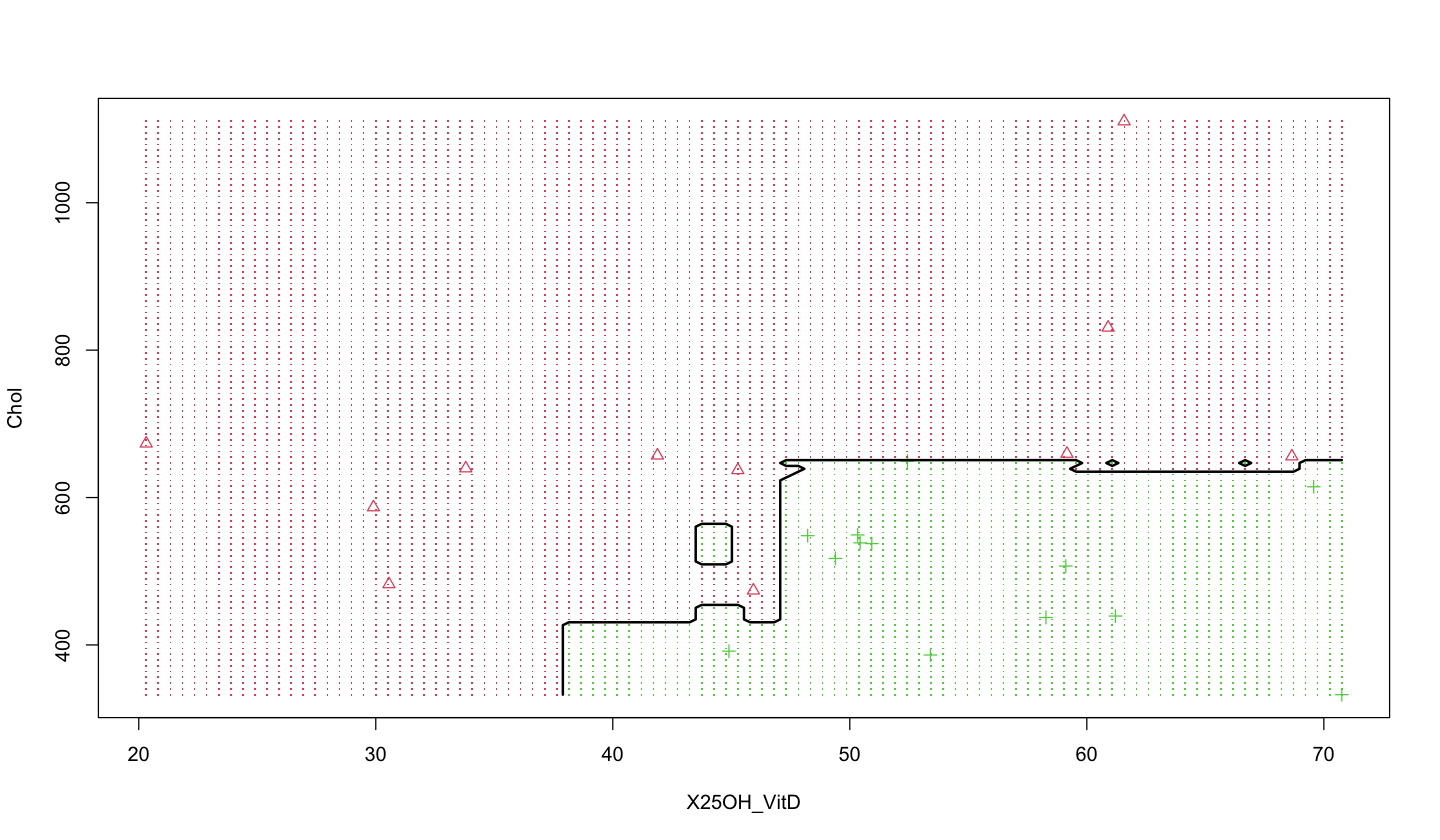

In [61]:
smaller_data = data.frame(lung_resp_df[,c("X25OH_VitD", "Chol", "Lung_Responder")])
rf_model = randomForest(Lung_Responder~., data = smaller_data)
boundary(rf_model, smaller_data, class = "Lung_Responder")

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1


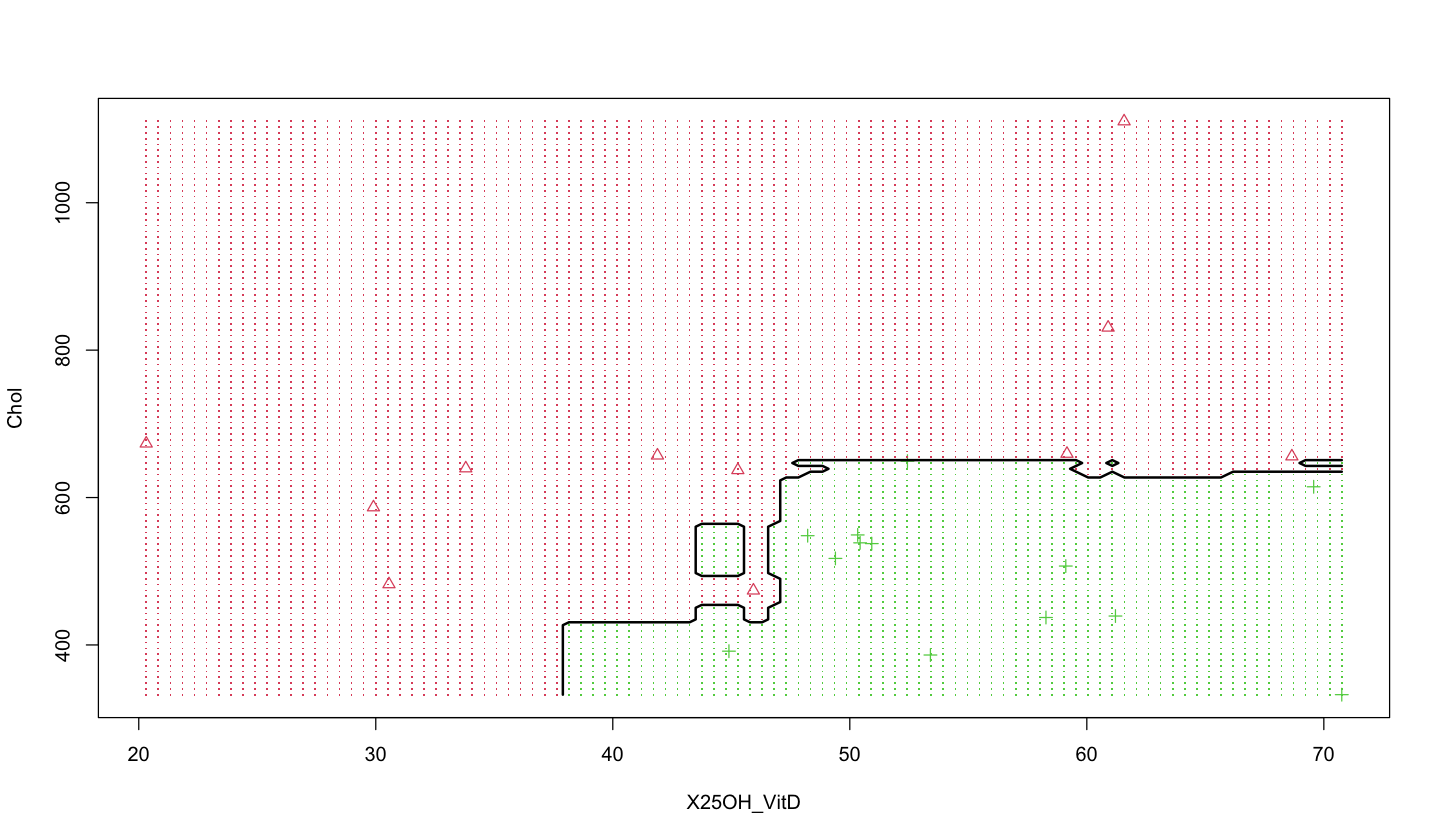

In [54]:
contour_fn <- function(model, data, class = NULL, predict_type = "class",
  resolution = 100, showgrid = TRUE, ...) {

  if(!is.null(class)) cl <- data[,class] else cl <- 1
  data <- data[,1:2]
  k <- length(unique(cl))

  plot(data, col = as.integer(cl)+1L, pch = as.integer(cl)+1L, ...)

  # make grid
  r <- sapply(data, range, na.rm = TRUE)
  xs <- seq(r[1,1], r[2,1], length.out = resolution)
  ys <- seq(r[1,2], r[2,2], length.out = resolution)
  g <- cbind(rep(xs, each=resolution), rep(ys, time = resolution))
  colnames(g) <- colnames(r)
  g <- as.data.frame(g)

  ### guess how to get class labels from predict
  ### (unfortunately not very consistent between models)
  p <- predict(model, g, type = predict_type)
  if(is.list(p)) p <- p$class
  p <- as.factor(p)

  if(showgrid) points(g, col = as.integer(p)+1L, pch = ".")

  z <- matrix(as.integer(p), nrow = resolution, byrow = TRUE)
  contour(xs, ys, z, add = TRUE, drawlabels = FALSE,
    lwd = 2, levels = (1:(k-1))+.5)

  return(data.frame(z))
}
contour_fn(rf_model, smaller_data, class = "Lung_Responder")

1 2 3 4 5 6 
0 0 0 0 0 0 
Levels: 0 1

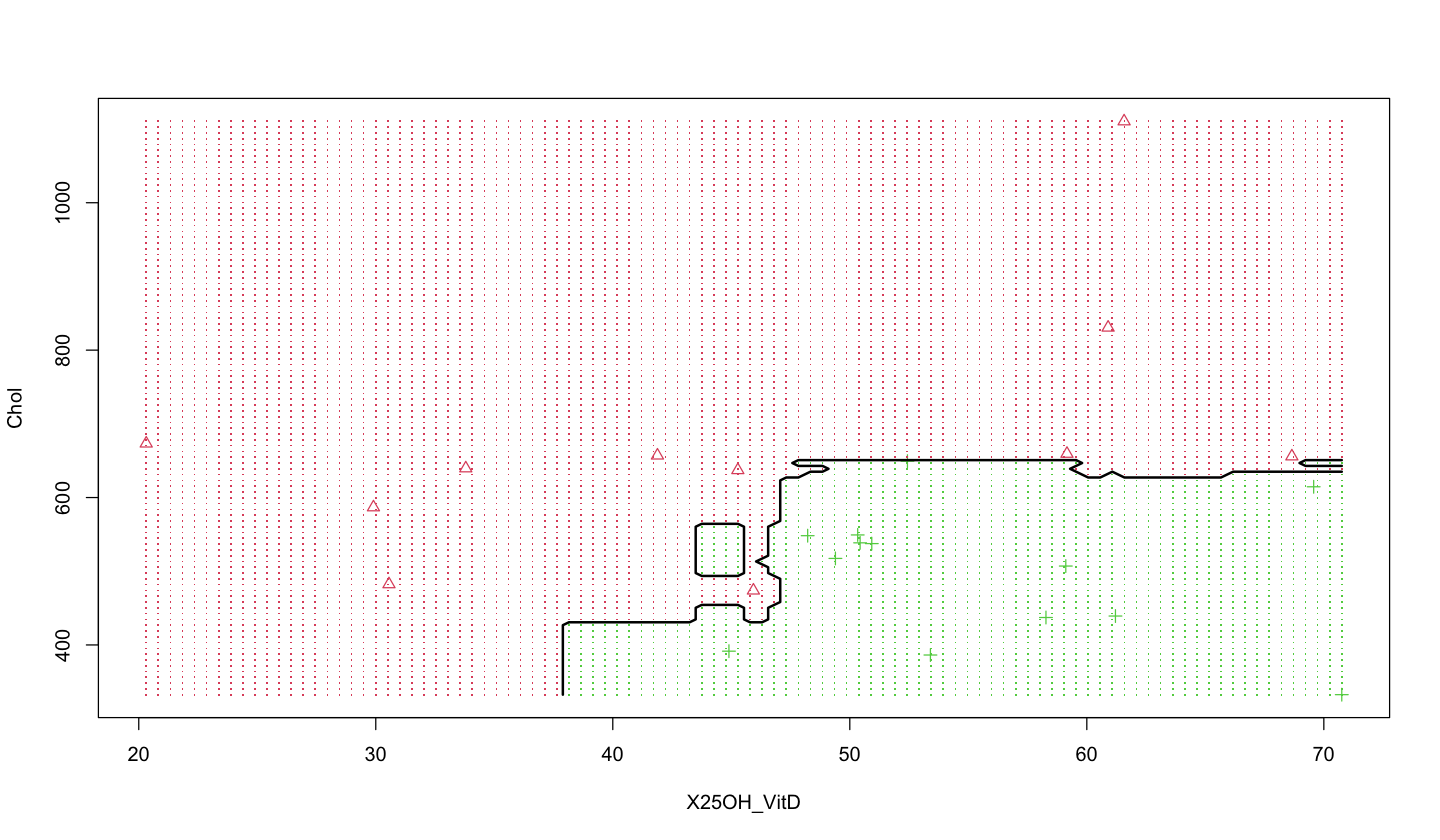

In [52]:
b = contour_fn(rf_model, smaller_data, class = "Lung_Responder")
head(b)

Version 2

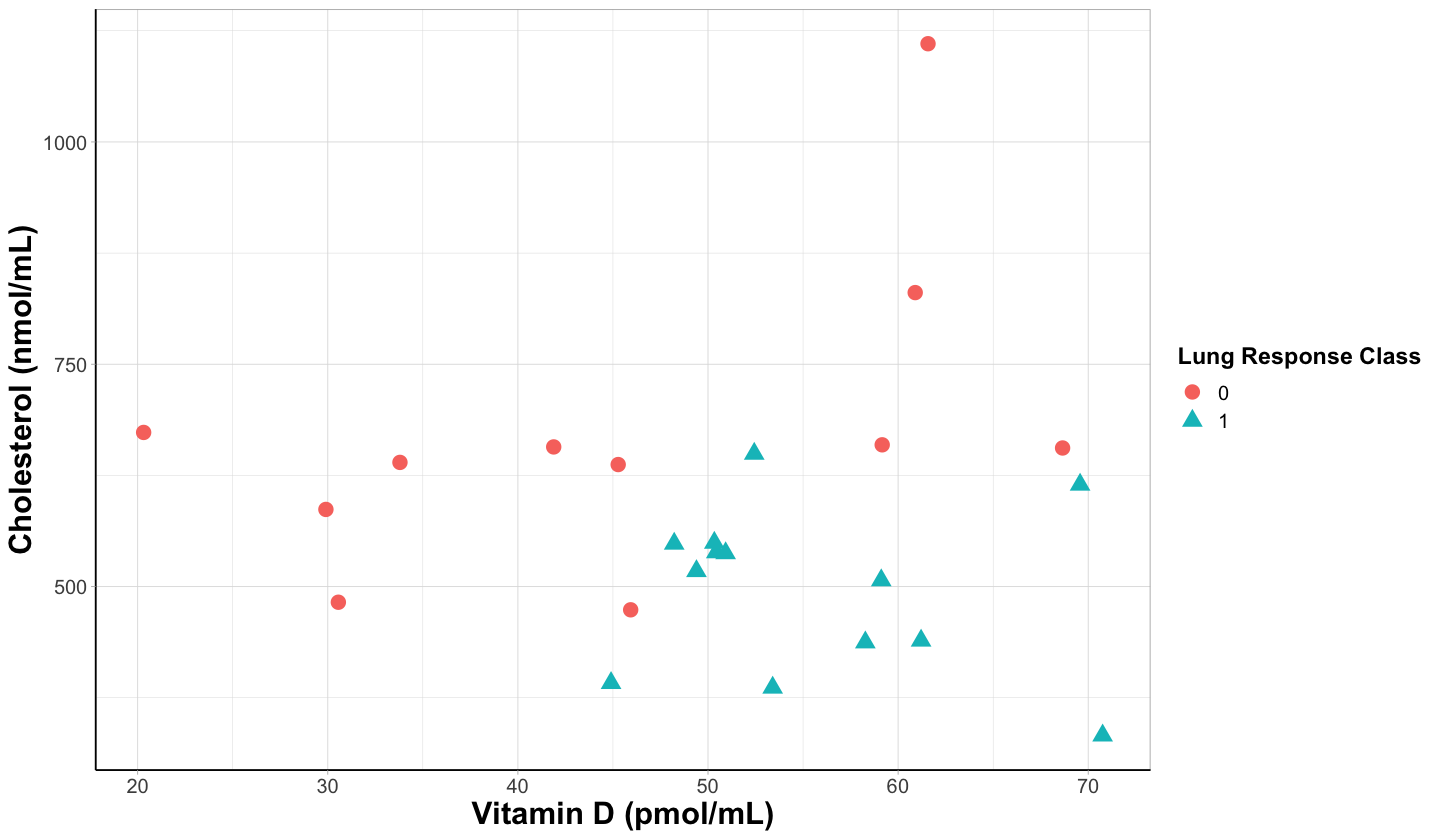

In [9]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
ggplot() +
  geom_point(data = lung_resp_df, aes(x = X25OH_VitD, y = Chol, color = Lung_Responder, shape = Lung_Responder),
            size = 4) + 

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  labs(x = 'Vitamin D (pmol/mL)', y = 'Cholesterol (nmol/mL)', color = "Lung Response \nClass", 
       shape = "Lung Response Class")  #changing axis labels 

In [14]:
install.packages("gganimate")
library(gganimate)

also installing the dependency ‘tweenr’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

No renderer backend detected. gganimate will default to writing frames to separate files
Consider installing:
- the `gifski` package for gif output
- the `av` package for video output
and restarting the R session



In [17]:
install.packages("mvnfast")
library(mvnfast)

also installing the dependency ‘BH’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [57]:
optimal_predict <- function(x, p_0, dfun_0, dfun_1) {
    ## Prior probability of class 1
    p_1 <- 1 - p_0
    ## Conditional probability of (x, y) given class 0
    p_x_0 <- dfun_0(x)
    ## Conditional probability of (x, y) given class 1
    p_x_1 <- dfun_1(x)
    ## Conditional probability of class 0 given (x, y)
    p_0_xy <- p_x_0 * p_0
    ## Conditional probability of class 1 given (x, y)
    p_1_xy <- p_x_1 * p_1
    optimal <- p_1_xy - p_0_xy
    class <- ifelse(optimal > 0, 1, 0)
    result <- c(p_0_xy, p_1_xy, optimal, class)
    names(result) <- c("p_0_xy", "p_1_xy", "optimal", "class")
    result
}

In [58]:
make_density_mvn <- function(mean_0, sigma_0, mean_1, sigma_1, p_0,
                             x_min, x_max, y_min, y_max, delta = 0.05) {
    x <- seq(x_min, x_max, delta)
    y <- seq(y_min, y_max, delta)
    density_mvn <- expand.grid(x, y)
    names(density_mvn) <- c("x", "y")
    dfun_0 <- function(x) mvnfast::dmvn(x, mu_0, sigma_0)
    dfun_1 <- function(x) mvnfast::dmvn(x, mu_1, sigma_1)
    optimal_mvn <- function(x, y) optimal_predict(c(x, y), p_0, dfun_0, dfun_1)
    density_mvn <- as_tibble(
        cbind(density_mvn,
              t(mapply(optimal_mvn,
                       density_mvn$x, density_mvn$y))))
    density_mvn
}

#calling fn
p <- 0.5
mu_0 <- c(0, 2)
sigma_0 <- matrix(c(1, 0.3, 0.3, 1), nrow = 2)
mu_1 <- c(2, 0)
sigma_1 <- matrix(c(1, -0.3, -0.3, 1), nrow = 2)

density_mvn <- make_density_mvn(mu_0, sigma_0, mu_1, sigma_1, p,
                                -3, 5, -3, 5)

In [81]:
#calculating means of each variable
x = as.matrix(smaller_data[,1:2])
one = as.matrix(rep(1, dim(x)[1]))
n <- dim(x)[1] # number of observations
xbar <- 1/n*t(x)%*%one #  calculate means of all columns
print(xbar)

                [,1]
X25OH_VitD  50.70503
Chol       577.30592


In [83]:
#calculating covariance matrices
mean_matrix <- matrix(data = 1, nrow = n)%*%cbind(xbar[[1]], xbar[[2]])
x_star <- x - mean_matrix 
covar_matrix <- 1/(n-1)*t(x_star)%*%x_star # Covariance matrix
print(covar_matrix)

           X25OH_VitD        Chol
X25OH_VitD  167.05622    53.61467
Chol         53.61467 25806.20457


In [87]:
mu

[1] 53.61467

In [ ]:
non_responders = lung_resp_df %>% 
    filter(Lung_Responder == "0")

In [67]:
make_mvn_sample <- function(n, mu_0, sigma_0, mu_1, sigma_1, p_0) {
    n_0 <- rbinom(1, n, p_0)
    n_1 <- n - n_0
    sample_mvn <- as_tibble(
        rbind(mvnfast::rmvn(n_0,
                            mu = mu_0,
                            sigma = sigma_0),
              mvnfast::rmvn(n_1,
                            mu = mu_1,
                            sigma = sigma_1)))
    sample_mvn[1:n_0, 3] <- 0
    sample_mvn[(n_0 + 1):(n_0 + n_1), 3] <- 1
    sample_mvn <- sample_mvn[sample(nrow(sample_mvn)), ]
    colnames(sample_mvn) <- c("x", "y", "class")
    sample_mvn
}
n <- 4000
set.seed(31415)
sample_mvn <- make_mvn_sample(n,
                              mu_0, sigma_0,
                              mu_1, sigma_1,
                              p)


Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


In [70]:
gg_density <- function(data, z, size = 1, color = "black", alpha = 1, ...) {
    z <- ensym(z)
    geom_contour(data = data,
                 aes(x, y, z = !!z),
                 size = size,
                 color = color,
                 alpha = alpha,
                 ...)
}

In [71]:
gg_optimal <- function(data, breaks = c(0), ...) {
    gg_density(data, z = optimal, breaks = breaks, ...)
}

In [72]:
gg_sample <- function(data, classes = NULL, size = 3, alpha = 0.5, ...) {
    if (is.null(classes)) {
        subdata <- data
    } else {
        subdata <- filter(data, class %in% classes)
    }
    list(geom_point(data = subdata,
                    aes(x, y,
                        color = factor(class),
                        shape = factor(class)),
                    size = size,
                    alpha = alpha,
                    ...),
         scale_colour_discrete(drop = TRUE,
                               limits = levels(factor(data$class))))
}

In [75]:
head(sample_mvn)
head(density_mvn)

x,y,class
<dbl>,<dbl>,<dbl>
3.18515052,-0.87841464,1
0.22021191,-0.69852617,1
3.81150902,1.06065575,1
-0.04689162,1.26649807,0
1.03211404,1.25924618,0
0.63717902,0.05720518,0


x,y,p_0_xy,p_1_xy,optimal,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-3.00,-3,9.029961e-08,4.575786e-12,-9.029504e-08,0
-2.95,-3,9.792258e-08,6.319125e-12,-9.791626e-08,0
-2.90,-3,1.058977e-07,8.702721e-12,-1.058890e-07,0
-2.85,-3,1.142082e-07,1.195254e-11,-1.141963e-07,0
-2.80,-3,1.228330e-07,1.637088e-11,-1.228166e-07,0
-2.75,-3,1.317466e-07,2.236097e-11,-1.317242e-07,0


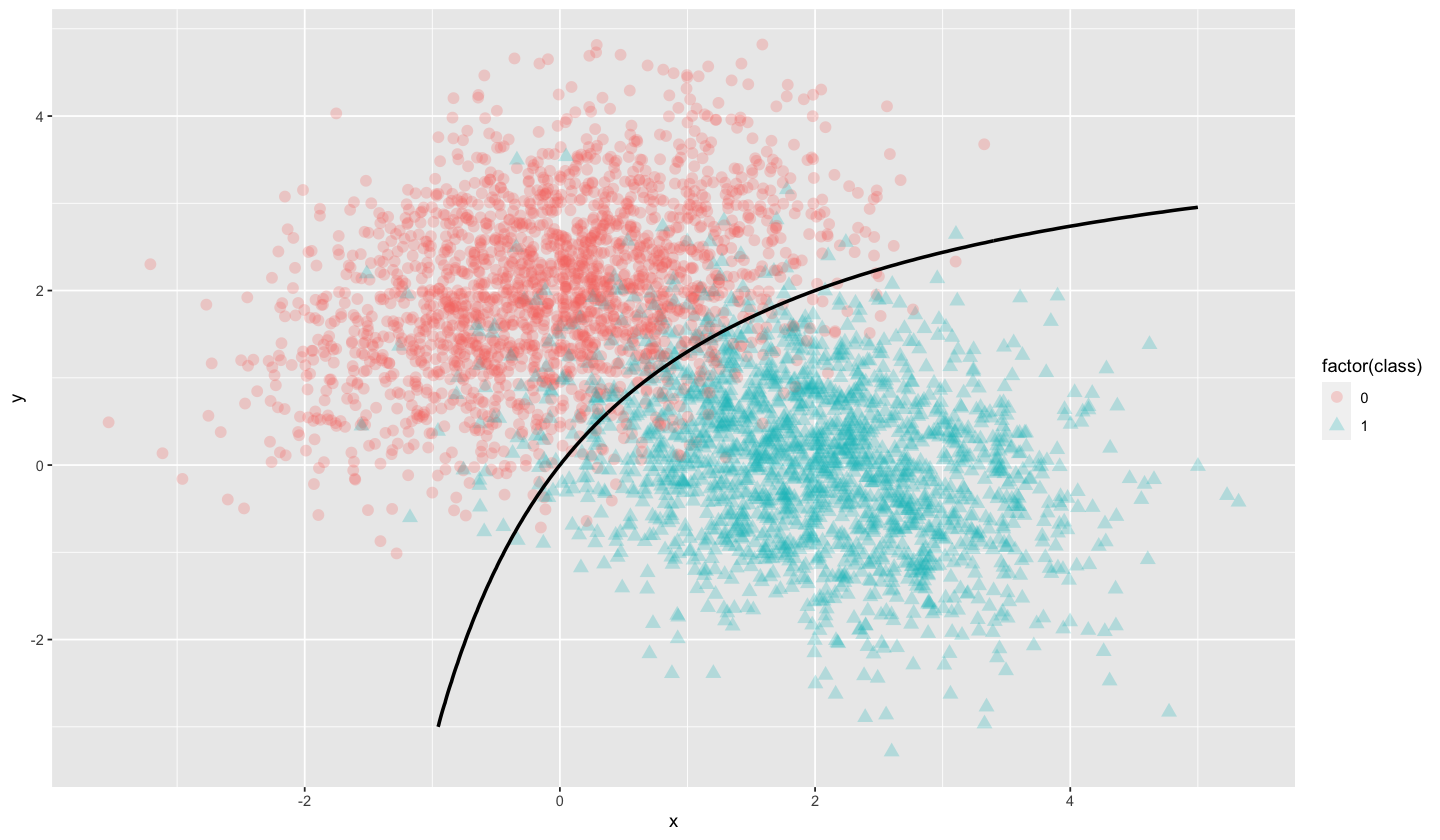

In [73]:
ggplot() +
 gg_sample(sample_mvn, alpha = 0.25) +
 gg_optimal(density_mvn)

In [ ]:
ggplot() +
  gg_sample(smaller_data) + 
  gg_optimal()